In [1]:
from pandas import read_csv, DataFrame, to_numeric
import numpy as np
import re
from matplotlib.pyplot import figure, show, savefig
from sklearn.model_selection import train_test_split

from dslab_functions import get_variable_types, naive_Bayes_study, knn_study, CLASS_EVAL_METRICS, plot_multibar_chart

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = naive_Bayes_study(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = knn_study(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            print(f"{met}: {eval_NB[met]} vs {eval_KNN[met]}")
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

# read file
filename = "class_credit_score.csv"
file_tag = "class_credit_score"
data : DataFrame = read_csv('class_credit_score.csv')

# VARIABLE ENCODING

- ID: drop
- Binary vars: ole              
- Month: ole         
- Name: drop			
- SSN: drop						
- Occupation: oebt					
- Type_of_Loan:	dummy, other					
- CreditMix: ole					
- Credit_History_Age: other						
- Payment_Behaviour: oebt			

In [2]:
def data_cleaning(df: DataFrame):
    variable_types: dict[str, list] = get_variable_types(df)

    # Age
    df['Age'] = to_numeric(df['Age'], errors='coerce')
    df['Age'] = np.where((df['Age'].isnull()) | (df['Age'] < 0) | (df['Age'] > 120), np.nan, df['Age'])
    
    # Monthly Balance
    df['MonthlyBalance'] = df['MonthlyBalance'].replace(-3.33333E+26, np.nan)
    
    # Num_Bank_Accounts
    df['Num_Bank_Accounts'] = np.where(df['Num_Bank_Accounts'] < 0, np.nan, df['Num_Bank_Accounts'])
    
    # NumofLoan
    df['NumofLoan'] = np.where(df['NumofLoan'] < 0, np.nan, df['NumofLoan'])
    
    # Delay_from_due_date
    df['Delay_from_due_date'] = np.where(df['Delay_from_due_date'] < 0, np.nan, df['Delay_from_due_date'])
    
    # NumofDelayedPayment
    df['NumofDelayedPayment'] = np.where(df['NumofDelayedPayment'] < 0, np.nan, df['NumofDelayedPayment'])
    
    # ChangedCreditLimit
    df['ChangedCreditLimit'] = np.where(df['ChangedCreditLimit'] < 0, np.nan, df['ChangedCreditLimit'])

data_cleaning(data)

In [3]:
vars: dict[str, list] = get_variable_types(data)
print(vars["binary"])
print(vars["symbolic"])

data.describe()

['Credit_Score']
['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Occupation', 'Type_of_Loan', 'CreditMix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,NumofLoan,Delay_from_due_date,NumofDelayedPayment,ChangedCreditLimit,NumCreditInquiries,OutstandingDebt,CreditUtilizationRatio,TotalEMIpermonth,Amountinvestedmonthly,MonthlyBalance
count,92377.000000,1.000000e+05,84998.000000,99979.000000,100000.00000,100000.000000,96124.000000,99409.000000,92354.000000,96323.000000,98035.000000,100000.000000,100000.000000,100000.000000,95521.000000,98791.000000
mean,33.322580,1.764157e+05,4194.170850,17.095080,22.47443,72.466040,7.163622,21.207245,31.150519,10.599042,27.754251,1426.220376,32.285173,1403.118217,637.412998,402.551258
std,10.797911,1.429618e+06,3183.686167,117.416871,129.05741,466.422621,60.314923,14.794693,226.802173,6.639966,193.177339,1155.129026,5.116875,8306.041270,2043.319327,213.925499
min,14.000000,7.005930e+03,303.645417,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,20.000000,0.000000,0.000000,0.007760
25%,24.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,2.000000,10.000000,9.000000,5.570000,3.000000,566.072500,28.052567,30.306660,74.534002,270.106630
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.520000,6.000000,1166.155000,32.305784,69.249473,135.925681,336.731225
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,15.010000,9.000000,1945.962500,36.496663,161.224249,265.731733,470.262938
max,118.000000,2.419806e+07,15204.633330,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,10000.000000,1602.040519


### BINARY

In [4]:
# encode binary
def encoding_credit_score(data: DataFrame): 
    df2: DataFrame = data
    df2["Credit_Score"] = data.apply(lambda x: 1 if x["Credit_Score"] == "Good" else 0 if x["Credit_Score"] == "Poor" else None, axis=1)
    return df2


### SYMBOLIC

In [5]:
columns = ['ID', 'Customer_ID', 'Name', 'SSN']
existing_columns = [col for col in columns if col in data.columns]
if len(existing_columns) > 0:
    data.drop(columns = existing_columns, inplace = True)
data.dropna()

vars: dict[str, list] = get_variable_types(data)
for v in vars["symbolic"]:
    print(v, data[v].unique())

Month ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
Occupation ['Scientist' nan 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']
Type_of_Loan ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loan, Student Loan, Mortgage Loan, and Not Specified'
 'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan']
CreditMix [nan 'Good' 'Standard' 'Bad']
Credit_History_Age ['22 Years and 1 Months' nan '22 Years and 3 Months'
 '22 Years and 4 Months' '22 Years and 5 Months' '22 Years and 6 Months'
 '22 Years and 7 Months' '26 Years and 7 Months' '26 Years and 8 Months'
 '26 Years and 9 Months' '26 Years and 10 Months' '26 Years and 11 Months'
 '27 Years and 0 Months' '27 Years and 1 Months' '27

In [7]:
#encode symbolic
def encoding_credit_age(data: DataFrame):
    df2: DataFrame = data

    def convert_to_int(value):
        try:
            if re.findall(r'\d+', str(value)) == []:
                return None
            yearsToMonth = int(re.findall(r'\d+', str(value))[0]) * 12
            sumMonths = yearsToMonth + int(re.findall(r'\d+', str(value))[1])
          
            return sumMonths
        except (ValueError, TypeError):
            return None  # Or any other appropriate value indicating the failure to convert
    df2["Credit_History_Age"] = data.apply(lambda x: convert_to_int(x["Credit_History_Age"]), axis=1)
     
    return df2

def encoding_ssn(data: DataFrame):
    
    def convert_to_float(value):
        try:
            return float(re.sub(r'\D+', '', str(value)))
        except (ValueError, TypeError):
            return None  # Or any other appropriate value indicating the failure to convert
        
    df2: DataFrame = data
    df2["SSN"] = data.apply(lambda x: convert_to_float(x["SSN"]), axis=1)
    return df2

def encoding_month(data: DataFrame): 
    df2: DataFrame = data
    df2["Month"] = data.apply(lambda x: 1 if x["Month"] == "January" else 2 if x["Month"] == "February" else 3 if x["Month"] == "March"
                              else 4 if x["Month"] == "April" else 5 if x["Month"] == "May" else 6 if x["Month"] == "June" else 7 if
                              x["Month"] == "July" else 8 if x["Month"] == "August" else None, axis=1)
    return df2

def encoding_creditmix(data: DataFrame): 
    df2: DataFrame = data
    df2["CreditMix"] = data.apply(lambda x: 2 if x["CreditMix"] == "Good" 
                                  else 1 if x["CreditMix"] == "Standard" else 0 if x["CreditMix"] == "Bad" else None, axis=1)
    return df2

def encoding_payment_min(data: DataFrame):
    df2: DataFrame = data
    df2["Payment_of_Min_Amount"] = data.apply(lambda x: 2 if x["Payment_of_Min_Amount"] == "NM" 
                                  else 1 if x["Payment_of_Min_Amount"] == "Yes" else 0 if x["Payment_of_Min_Amount"] == "No" else None, axis=1)
    return df2

def encoding_payment_behaviour(data: DataFrame):
    df2: DataFrame = data
    df2["Payment_Behaviour"] = data.apply(lambda x: 1 if x["Payment_Behaviour"] == "Low_spent_Small_value_payments" 
                                  else 2 if x["Payment_Behaviour"] == "Low_spent_Medium_value_payments" else 3 
                                  if x["Payment_Behaviour"] == "Low_spent_Large_value_payments" else 4 if 
                                  x["Payment_Behaviour"] == "High_spent_Small_value_payments" 
                                  else 5 if x["Payment_Behaviour"] == "High_spent_Medium_value_payments" else 6 
                                  if x["Payment_Behaviour"] == "High_spent_Large_value_payments" else None, axis=1)
    return df2

def encoding_loans(data: DataFrame):
    df2: DataFrame = data
    for idx, x in df2["Type_of_Loan"].items():
        try:
            #splits the different loans of the string
            split = re.split(r', and |, ', x)  
        except (ValueError, TypeError):
            continue
        for n in split:
            #if it isnt in the columns, creates a new one with 0 on all cells
            if n not in df2.columns:
                df2[n] = 0
            else:
            #otherwhise add 1 to the cell
                df2.at[idx, n] += 1
    df2.drop(columns = ['Type_of_Loan'], inplace = True)
    return df2

def encoding_occupations(data: DataFrame):
    df2: DataFrame = data
    df2["Occupation"] = data.apply(lambda x: 1 if x["Occupation"] == "Doctor" 
                                  else 2 if x["Occupation"] == "Architect" else 3 
                                  if x["Occupation"] == "Engineer"  else 4 if x["Occupation"] == "Mechanic" 
                                  else 5 if x["Occupation"] == "Developer"  else 6 
                                  if x["Occupation"] == "Scientist"  else 7 if x["Occupation"] == "Teacher" else
                                  8 if x["Occupation"] == "Accountant" else 9 if x["Occupation"] == "Manager" else
                                  10 if x["Occupation"] == "Entrepeneur" else 11 if x["Occupation"] == "Lawyer" else
                                  12 if x["Occupation"] == "Journalist" else 13 if x["Occupation"] == "Writer" else
                                  14 if x["Occupation"] == "Media Manager" else 15 if x["Occupation"] == "Musician" else
                                  None, axis=1)
    return df2

data = encoding_credit_age(data)
#data = encoding_ssn(data)
data = encoding_month(data)
data = encoding_creditmix(data)
data = encoding_payment_min(data)
data = encoding_payment_behaviour(data)
data = encoding_loans(data)
data = encoding_occupations(data)
data = data[[col for col in data.columns if col != 'Credit_Score'] + ['Credit_Score']]
data = encoding_credit_score(data)

vars: dict[str, list] = get_variable_types(data)
print(vars["symbolic"])
print(vars["binary"])
print(vars["numeric"])


[]
['Credit_Score']
['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'NumofLoan', 'Delay_from_due_date', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'CreditMix', 'OutstandingDebt', 'CreditUtilizationRatio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'TotalEMIpermonth', 'Amountinvestedmonthly', 'Payment_Behaviour', 'MonthlyBalance', 'Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan', 'Not Specified', 'Mortgage Loan', 'Student Loan', 'Debt Consolidation Loan', 'Payday Loan']


# MISSING VALUES IMPUTATION

Dataset nr records=100000 nr variables=32


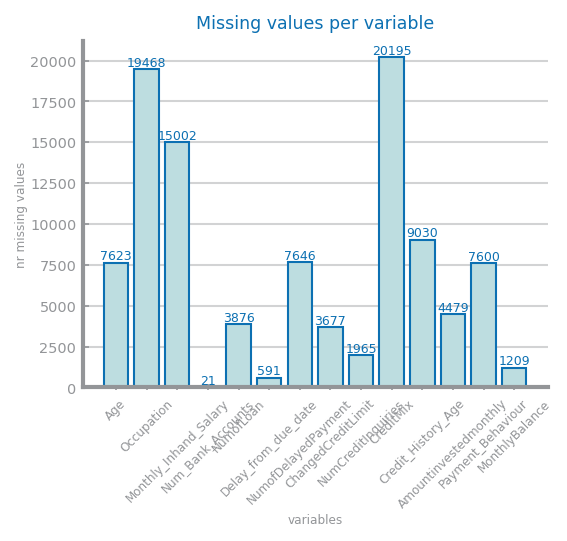

In [8]:
from dslab_functions import mvi_by_dropping, mvi_by_filling
from dslab_functions import plot_bar_chart

print(f"Dataset nr records={data.shape[0]}", f"nr variables={data.shape[1]}")

mv: dict[str, int] = {}
figure()
for var in data:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
show()

### DROPPING MISSING VALUES

In [9]:
df: DataFrame = data.dropna(how="any", inplace=False)
df.shape

(33411, 32)

In [10]:
df: DataFrame = data.dropna(how="all", inplace=False)
df.shape

(100000, 32)

In [11]:
df: DataFrame = mvi_by_dropping(data, min_pct_per_variable=0.7, min_pct_per_record=0.9)
df.shape

(98776, 32)

### FILLING MISSING VALUES

In [12]:
df: DataFrame = mvi_by_filling(data, strategy="frequent")
df.head(10)
#df.describe()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,NumofLoan,Delay_from_due_date,...,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Not Specified,Mortgage Loan,Student Loan,Debt Consolidation Loan,Payday Loan,Credit_Score
0,1.0,23.00000,6.000000,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2.0,23.00000,6.000000,19114.12,4194.170850,3.0,4.0,3.0,4.0,21.207245,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,3.0,33.32258,6.000000,19114.12,4194.170850,3.0,4.0,3.0,4.0,3.000000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,4.0,23.00000,6.000000,19114.12,4194.170850,3.0,4.0,3.0,4.0,5.000000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,5.0,23.00000,6.000000,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.000000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
5,6.0,23.00000,6.000000,19114.12,4194.170850,3.0,4.0,3.0,4.0,8.000000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
6,7.0,23.00000,6.000000,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.000000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
7,8.0,23.00000,6.000000,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.000000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
8,1.0,28.00000,7.325349,34847.84,3037.986667,2.0,4.0,6.0,1.0,3.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,2.0,28.00000,7.000000,34847.84,3037.986667,2.0,4.0,6.0,1.0,7.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [13]:
df.describe()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,NumofLoan,Delay_from_due_date,...,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Not Specified,Mortgage Loan,Student Loan,Debt Consolidation Loan,Payday Loan,Credit_Score
count,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.500000,33.322580,7.325349,1.764157e+05,4194.170850,17.095080,22.47443,72.466040,7.163622,21.207245,...,0.379910,0.40439,0.388870,0.391030,0.396150,0.389350,0.389670,0.387750,0.405670,0.710020
std,2.291299,10.378187,3.790260,1.429618e+06,2935.176493,117.404542,129.05741,466.422621,59.134457,14.750909,...,0.640174,0.66746,0.645643,0.646877,0.650922,0.642496,0.649978,0.645077,0.664279,0.453755
min,1.000000,14.000000,1.000000,7.005930e+03,303.645417,0.000000,0.00000,1.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.750000,25.000000,4.000000,1.945750e+04,1792.084167,3.000000,4.00000,8.000000,2.000000,10.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,33.322580,7.325349,3.757861e+04,3852.736667,6.000000,5.00000,13.000000,3.000000,18.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.250000,41.000000,9.000000,7.279092e+04,5371.525000,7.000000,7.00000,20.000000,6.000000,28.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,8.000000,118.000000,15.000000,2.419806e+07,15204.633330,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,...,4.000000,4.00000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [14]:
target = 'Credit_Score'
X, y = df.loc[:, df.columns != 'Credit_Score'], df['Credit_Score']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33)

Xtrain['Credit_Score'] = Ytrain
Xtest['Credit_Score'] = Ytest
train, test = Xtrain, Xtest

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()

# OUTLIERS

### DROP OUTLIERS

In [77]:
from pandas import read_csv, DataFrame, Series

from dslab_functions import NR_STDEV, get_variable_types, determine_outlier_thresholds_for_var

file_tag = "class_credit_score"
data : DataFrame = read_csv('class_credit_score.csv')
print(f"Original data: {data.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data)["numeric"]
if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var]
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"data/{file_tag}_drop_outliers.csv", index=True)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")

Original data: (100000, 28)
Data after dropping outliers: (68895, 28)


### REPLACING OUTLIERS WITH FIXED VALUES

In [78]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv(f"data/{file_tag}_replacing_outliers.csv", index=True)
    print("Data after replacing outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (100000, 28)
       Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count   1.000000e+05           84998.000000      100000.000000   
mean    5.212109e+04            3680.233822           5.594350   
std     6.988379e+04            2490.342766           6.500417   
min     7.005930e+03             303.645417          -1.000000   
25%     1.945750e+04            1625.568229           3.000000   
50%     3.757861e+04            3093.745000           6.000000   
75%     7.153080e+04            5223.795000           7.000000   
max     3.035422e+06           10559.030000         246.000000   

       Num_Credit_Card  Interest_Rate      NumofLoan  Delay_from_due_date  \
count    100000.000000  100000.000000  100000.000000        100000.000000   
mean          6.145450      16.355210      -0.458560            18.390260   
std          10.748865      36.329355      20.173739            11.208212   
min           0.000000       1.000000    -100.000000 

### TRUNCATING OUTLIERS

In [79]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv(f"data/{file_tag}_truncate_outliers.csv", index=True)
    print("Data after truncating outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Data after truncating outliers: (100000, 28)
       Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count   1.000000e+05           84998.000000      100000.000000   
mean    7.859408e+04            4099.582521           8.390244   
std     2.877181e+05            2943.757387          26.911456   
min     7.005930e+03             303.645417          -1.000000   
25%     1.945750e+04            1625.568229           3.000000   
50%     3.757861e+04            3093.745000           6.000000   
75%     7.279092e+04            5957.448333           7.000000   
max     3.035652e+06           10561.543183         251.900949   

       Num_Credit_Card  Interest_Rate      NumofLoan  Delay_from_due_date  \
count    100000.000000  100000.000000  100000.000000        100000.000000   
mean         11.177710      33.016116       0.082761            20.662865   
std          38.282323     132.149164      21.869211            13.899732   
min           0.000000       1.000000    -100.000000

# SCALING

### STANDART SCALER (need encoding)

In [80]:
#doesn't work yet
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

file = "class_credit_score"
data : DataFrame = read_csv('class_credit_score.csv')

target = "Credit_Score"
vars: list[str] = data.columns.to_list()
target_data: Series = data.pop(target)

transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data)
df_zscore = DataFrame(transf.transform(data), index=data.index)
df_zscore[target] = target_data
df_zscore.columns = vars
df_zscore.to_csv(f"data/{file}_scaled_zscore.csv", index=True)

ValueError: could not convert string to float: '0x1602'

### MINMAX SCALER

In [81]:
from sklearn.preprocessing import MinMaxScaler

transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index)
df_minmax[target] = target_data
df_minmax.columns = vars
df_minmax.to_csv(f"data/{file}_scaled_minmax.csv", index=True)

ValueError: could not convert string to float: '0x1602'

### COMPARE ORIGINAL TO ZSCORE AND MINMAX

NameError: name 'df_zscore' is not defined

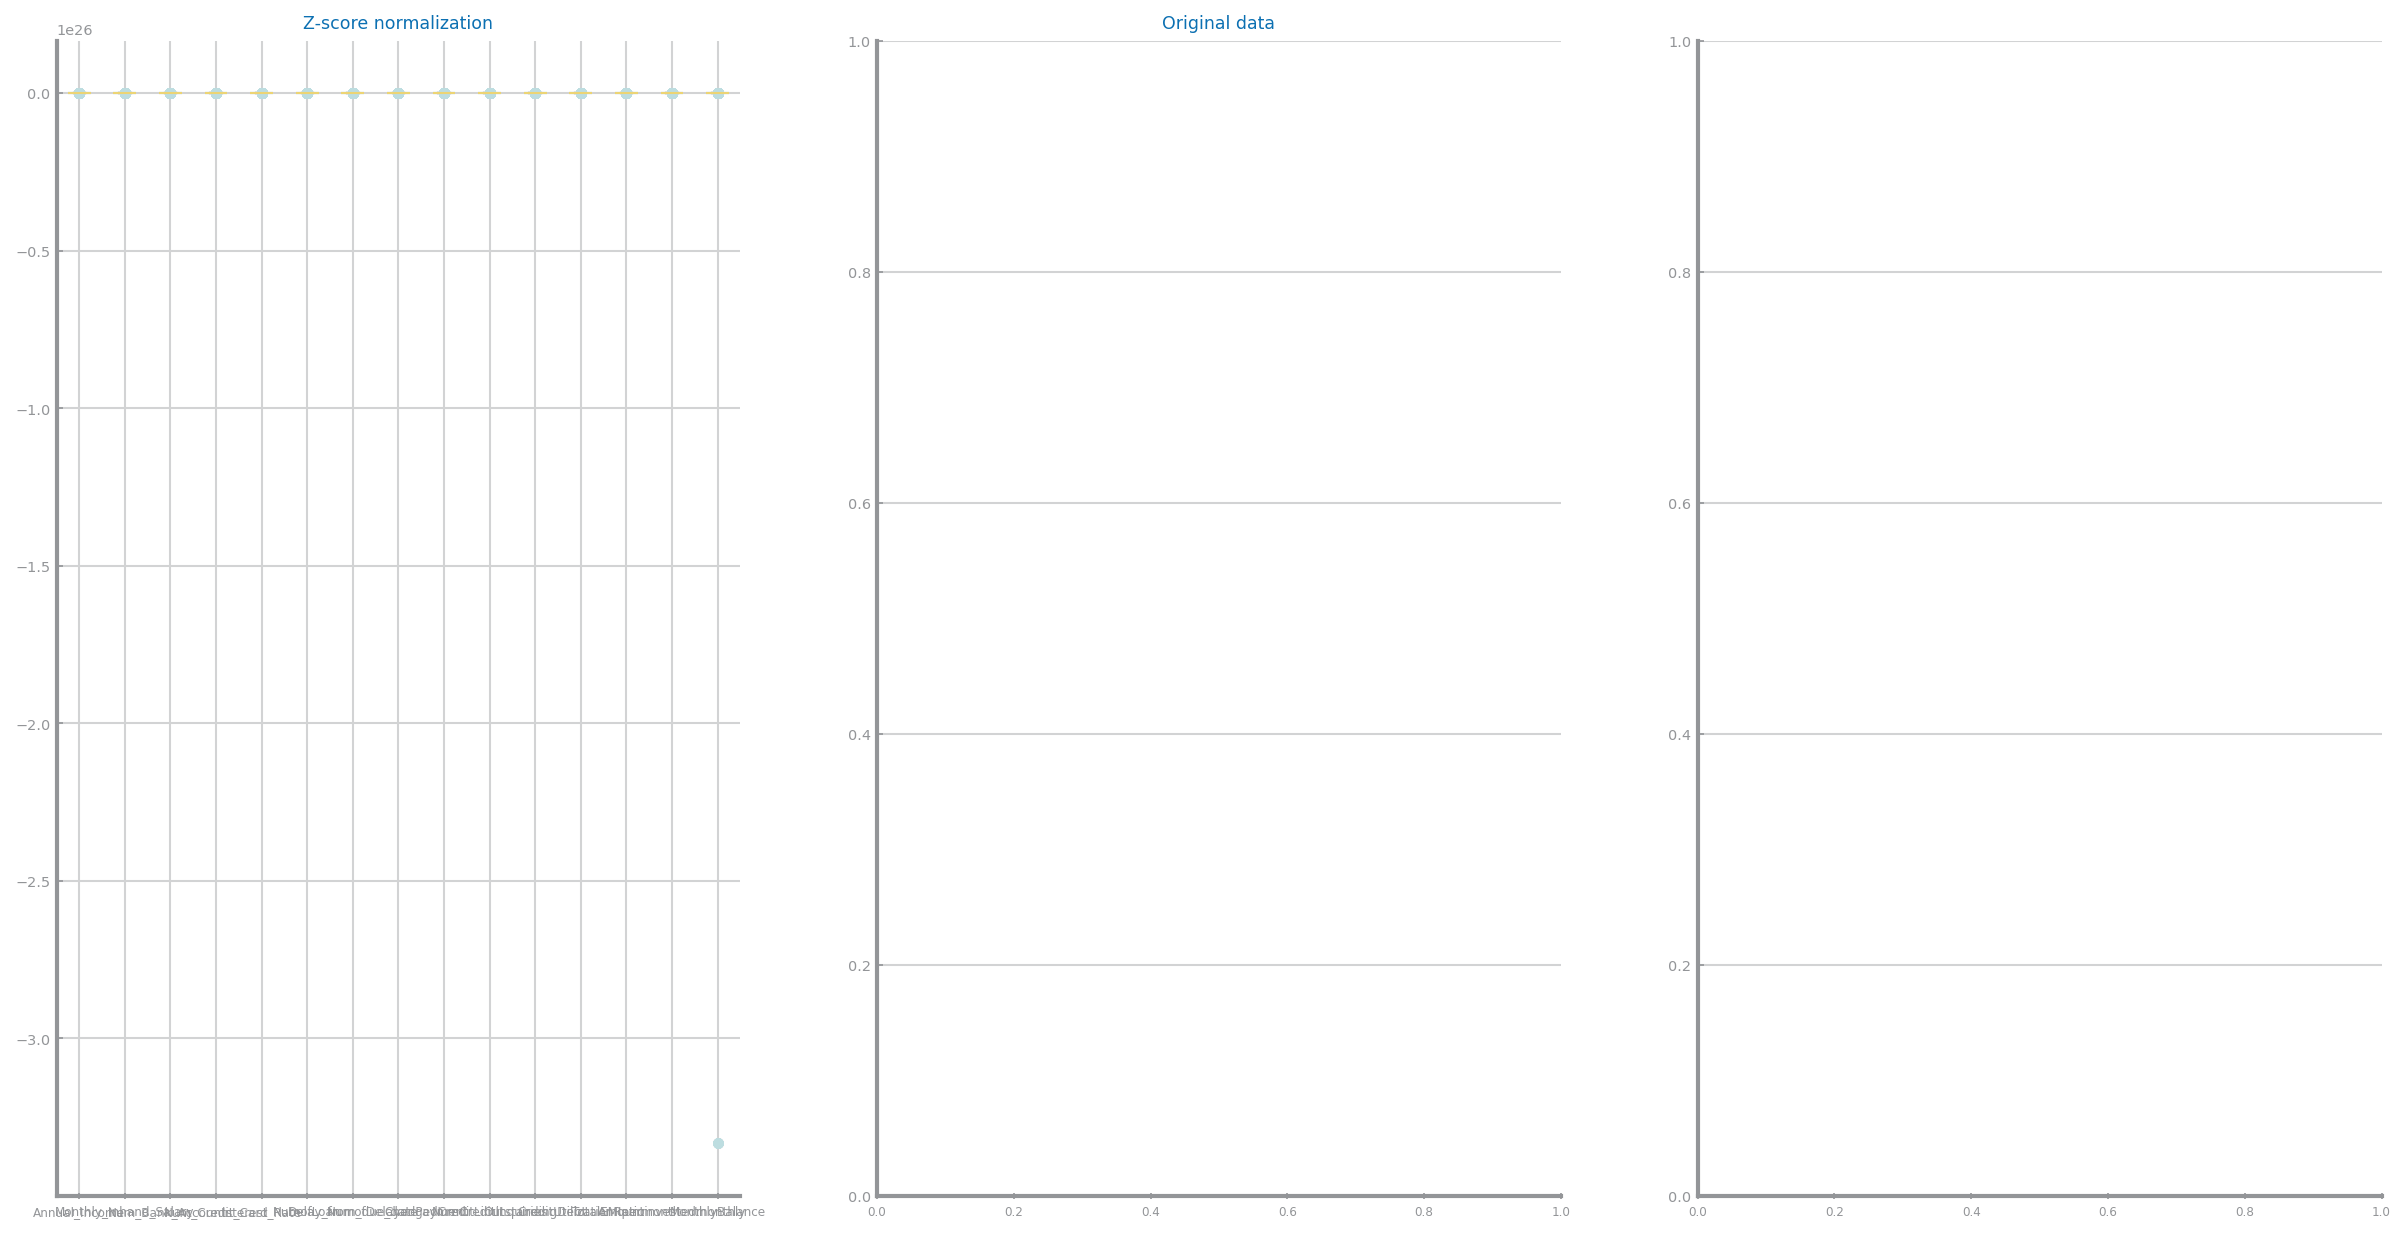

In [82]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

# BALANCING

Minority class= Poor : 28998
Majority class= Good : 71002
Proportion: 0.41 : 1


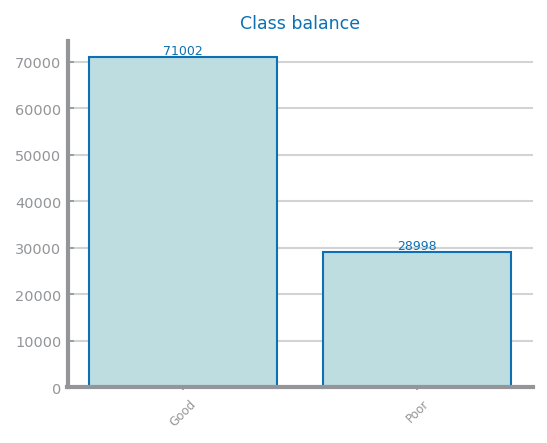

In [83]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslab_functions import plot_bar_chart

file = "class_credit_score"
target = "Credit_Score"
original: DataFrame = read_csv('class_credit_score.csv')

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(target_count.index.to_list(), target_count.to_list(), title="Class balance")
show()

In [84]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

In [85]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"data/{file}_under.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= Poor : 28998
Majority class= Good : 28998
Proportion: 1.0 : 1


### SMOTE (need encoding first)

In [87]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"data/{file}_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

ValueError: could not convert string to float: '0x1602'